In [1]:
from datasets import load_dataset
from transformers import pipeline
tiny_imagenet = load_dataset('Maysee/tiny-imagenet')

2025-05-07 16:07:18.209982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746634038.228601    5898 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746634038.233639    5898 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746634038.247462    5898 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746634038.247489    5898 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746634038.247491    5898 computation_placer.cc:177] computation placer alr

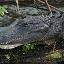

In [2]:
tiny_imagenet['train'][2300]['image']

### Versión A

In [3]:
#from operator import itemgetter
def get_best_class_and_score(classifier,pil_image):
    preds = classifier(pil_image)
    #newlist = sorted(preds, key=itemgetter('score'), reverse=True) # ya está ordenada
    return preds[0]

In [4]:
%%time
tiny_imagenet = load_dataset('Maysee/tiny-imagenet')
clf = pipeline("image-classification")

resultVersionA = []
for i in range(0, 10000, 40):
    resultVersionA.append(get_best_class_and_score(clf, tiny_imagenet["train"][i]["image"]))

No model was supplied, defaulted to google/vit-base-patch16-224 and revision 3f49326 (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


CPU times: user 10min 27s, sys: 4.14 s, total: 10min 31s
Wall time: 1min 27s


### Versión B

In [5]:
import ray

In [6]:
ray.shutdown()
ray.init()

2025-05-07 16:09:38,819	WARNING services.py:2159 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67104768 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=1.68gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-05-07 16:09:39,934	INFO worker.py:1879 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.11.2
Ray version:,2.45.0
Dashboard:,http://127.0.0.1:8265


In [7]:
%%time
tiny_imagenet = load_dataset('Maysee/tiny-imagenet')
clf = pipeline("image-classification")
rclf=ray.put(clf)

@ray.remote
def inference(classifier,image):
    return get_best_class_and_score(classifier,image)

resultVersionB = []
for i in range(0, 10000, 40):
    resultVersionB.append(inference.remote(rclf, tiny_imagenet["train"][i]["image"]))

resultVersionB = ray.get(resultVersionB)

No model was supplied, defaulted to google/vit-base-patch16-224 and revision 3f49326 (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


(inference pid=6784) 2025-05-07 16:10:24.870886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(inference pid=6785) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(inference pid=6785) E0000 00:00:1746634224.904859    6785 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(inference pid=6785) E0000 00:00:1746634224.925863    6785 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(inference pid=6785) W0000 00:00:1746634224.962660    6785 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(inference pid=6785) W0000 00:00:1746634224.964178    6785 computation

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: f38baf6030fd850b486cb569e92ae9ba92a7c52b01000000 Worker ID: 1544724d2fd974b584a5356ee33c64e940cecfd7bc3a1aec5bbc74e1 Node ID: e41a47c2625006f54bcc35f8c87e13fd981def3fe47afcadbcf36d6c Worker IP address: 172.17.0.2 Worker port: 45255 Worker PID: 6786 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker connection closed unexpectedly.


(raylet) 
(raylet) [2025-05-07 16:12:39,915 E 6723 6723] (raylet) node_manager.cc:3307: 5 Workers (tasks / actors) killed due to memory pressure (OOM), 1 Workers crashed due to other reasons at node (ID: e41a47c2625006f54bcc35f8c87e13fd981def3fe47afcadbcf36d6c, IP: 172.17.0.2) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.17.0.2`
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(inference pid=7633) 2025-05-07 16:13:35.782042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to r

In [ ]:
[l for i, l in enumerate(resultVersionA) if (resultVersionA[i]["label"] != resultVersionB[i]["label"])]

### Versión C

In [ ]:
@ray.remote
class InferenceEngine:
    def __init__(self,load_images=True):
        self.classifier = pipeline("image-classification")
        if load_images:
            self.dataset = load_dataset('Maysee/tiny-imagenet')['train']
        else:
            self.dataset= None

    def classify_image(self,i):
        if self.dataset is None or i>=len(self.dataset):
            return ("Error",1)

        ## A completar
        return self.classify_image_object(self.dataset["train"][i]["image"])

    def classify_image_object(self,image):
        ## A completar
        return get_best_class_and_score(self.classifier,image)